In [1]:
# simmulate sounds in a grid of parameter values
from __future__ import division
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import spectrogram
import scipy.signal as sg
import socket
import os
import sys
import logging
from mpi4py import MPI
import h5py
import copy


logger = logging.getLogger()
# handler = logging.StreamHandler()
# formatter = logging.Formatter(
#         '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
# handler.setFormatter(formatter)
# logger.addHandler(handler)
# logger.setLevel(logging.DEBUG)

# Check wich computer to decide where the things are mounted
comp_name=socket.gethostname()
#logger.info('Computer: ' + comp_name)

if 'txori' in comp_name or 'passaro' in comp_name or 'lintu' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

if 'lookfar' in comp_name:
    repos_folder = os.path.abspath('/Users/zeke/repos/')
    experiment_folder = os.path.join('/Users/zeke/bci_zf/')

sys.path.append(os.path.join(repos_folder, 'swissknife'))

#setup the data folder
from swissknife.h5tools import h5tools
from swissknife.h5tools import tables
from swissknife.dynamo import finch as zf
from swissknife.dynamo import takens as tk
from swissknife.bci.core import expstruct as es
from swissknife.threadtools import threadedfunction as td

def splitlist(a, n):
    k, m = len(a) / n, len(a) % n
    return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in xrange(n))

def chunkify(lst,n):
    return [ lst[i::n] for i in xrange(n) ]

def sim_and_store(sim_pars, h5_file):
    sweep_group = h5_file.require_group(sim_pars['sweep_name'])
    h5tools.dict_2_group(sweep_group, sim_pars['vocal_pars'], 'vocal_pars')
    synth_group = sweep_group.require_group('synth')
    # create the group for the gamma
    gamma_group = synth_group.require_group('{0:5d}'.format(sim_pars['gamma']))
    sweep_table = tables.unlimited_rows_data(gamma_group, 'alpha_beta', 
                                             np.array([sim_pars['alpha'], 
                                                       sim_pars['beta']]).reshape([1,2]))
                                            
    
    alpha_values = sim_pars['alpha'] * np.ones(sim_pars['sim_samples'])
    beta_values = sim_pars['beta'] * np.ones(sim_pars['sim_samples'])
    env_values = np.ones(sim_pars['sim_samples'])
    par_stream = np.array([alpha_values, beta_values, env_values]).T
    for key in ['alpha', 'beta', 'gamma', 's_f', 'steps_per_sample']:
        vocal_pars['sys'][key] = sim_pars[key]
    song_synth = zf.finch(vocal_pars, par_stream, x_0=sim_pars['x_0'])
    pin_table = tables.unlimited_rows_data(gamma_group, 'pre_in', 
                                           song_synth[:,1].reshape([1,-1]))
    pout_table = tables.unlimited_rows_data(gamma_group, 'pre_out', 
                                            song_synth[:,0].reshape([1,-1]))

319


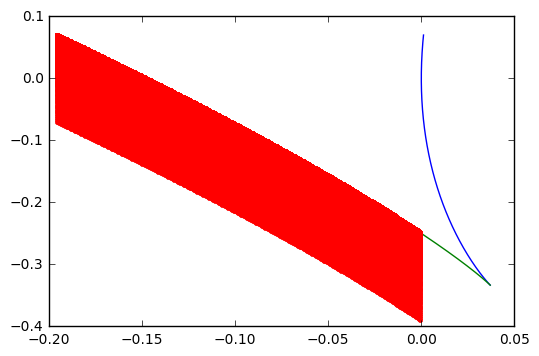

In [2]:
sys_pars = {'alpha_1': 0.15,
            'beta_1': 0.15,
            'alpha_2': 0.15,
            'beta_2': 0.15,
            'gamma': 23500.,
            'Ch_inv': 4.5E10,
            'Lb_inv': 1.E-4,
            'Lg_inv': 1/82.,
            'Rb': 5E6,
            'Rh': 6E5,
            'V_ext': 0.,
            'dV_ext': 0.,
            'noise': 0.,
            'envelope': 0.,
            'noise_fraction_beta_1': 0.1,
            'noise_fraction_env': 0.1,
            's_f': 44100.,
            'steps_per_sample': 20
            }

vocal_pars = {'sys': sys_pars,
              'S_1': 0.2,
              'S_2': 0.2,
              'S_3': 0.2,
              'l_1': 1.5,
              'l_2': 1.5,
              'l_3': 1.0,
              'r_out': 0.1,
              'r_12': None,
              'r_21': None,
              'r_23': None,
              'r_32': None,
              't_12': None,
              't_21': None,
              't_23': None,
              't_32': None,
              't_in': 0.5,
              'tau_1': None,
              'tau_2': None,
              'tau_3': None,
              'max_tau': None,
              'A_1': 0.,
              'A_2': None,
              'A_3': None}

#lines, ab_g= tk.cusp_grid()
lines, ab_g = tk.cusp_grid(b_max=0.07, b_min=-1/3 , a_step=1E-3, b_steps=500, b_log_step_exp=5, f_max=None)
plt.plot(lines[:,1], lines[:,0])
plt.plot(lines[:,2], lines[:,0])
plt.plot(ab_g[:,0], ab_g[:,1], '.')

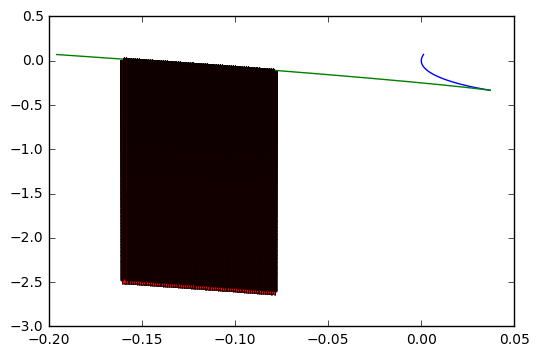

In [118]:
# upper line
plt.plot(lines[:,1], lines[:,0])
# lower line
plt.plot(lines[:,2], lines[:,0])
#get values that are a<0, b<lowerline

def cusp_grid(b_span, b_steps, a_max=-.08, a_min=-0.16, a_step=1e-3, b_log_step_exp=2):
    lines = tk.cusp_lines(step=a_step)
    b_sweep = np.logspace(0, b_log_step_exp, b_steps) * b_span  / (10 ** (b_log_step_exp))
    ab_grid = []
    for a in np.linspace(a_max, a_min, int(abs(a_max - a_min)/a_step)):
        b_m = lines[np.where(lines[:,2] < a)[0][0], 0]
        for b in b_sweep:
            ab_grid.append([a, b_m - b])
        
    return b_sweep, np.array(ab_grid)
        
l, abg = cusp_grid(2.5, 2000)
plt.plot(np.array(abg)[:,0], np.array(abg)[:,1], '*');

In [119]:
abg.shape

(160000, 2)

In [120]:
sweep_name = 'sweep_001'
sweep_file_path = os.path.join(es.file_names('')['folders']['tmp'], 'syn_sweeps', 'finch_00.h5')

sim_pars = {'sweep_name' : sweep_name,
            'gamma': 23500,
            'alpha': 0.,
            'beta': 0.,
            'vocal_pars': vocal_pars,
            'sim_samples': 4410,
            's_f': 44100.,
            'steps_per_sample': 20,
            'x_0': np.array([5.E-12, 1.E-11, 1.E-12, 1.E-11, 1.E-12])
           }

#s.mkdir_p(os.path.split(h5_path)[0])


@h5tools.h5_decorator(leave_open=False)
def sweep_to_file(h5_path, ab_list, sim_pars, mode='x'):
    logger.info('Sweeping {0} values of alpha, beta with g={1} to file {2}'.format(
            ab_list.shape[0], sim_pars['gamma'], h5_path))
    try:
        total_sim = ab_list.shape[0]
        count = 0
        round_count = 0
        
        for sim_pars['alpha'], sim_pars['beta'] in np.nditer([ab_list[:,0], ab_list[:,1]]):
            if round_count==0:
                logger.info('Simulating {0}/{1} with {0}, {1}'.format(count,
                                                                  total_sim, 
                                                                  sim_pars['alpha'],
                                                                  sim_pars['beta']))
                round_count = 50
                count+=50
            sim_and_store(sim_pars, h5_path)
            round_count-=1
        logger.info('Sweep done successfully')
    except UnboundLocalError, err:
        last_err = err
        logger.error(err)


def parallel_sweep(h5_path, ab_list, sim_pars, mode='x', threads=1):
    es.mkdir_p(os.path.split(h5_path)[0])
    logger.info('Sweeping {0} values of alpha, beta with g={1} to file {2} in {3} threads'.format(
            ab_list.shape[0], sim_pars['gamma'], h5_path, threads))
    try:
        sweep_threads = []
        f = h5py.File(h5_path, mode, driver='mpio', comm=MPI.COMM_WORLD)
        for chunk in chunkify(range(ab_list.shape[0]), threads):
            a_sweep = td.threadedFunction(args=(sweep_to_file,
                                                f,
                                                ab_list[chunk, :],
                                                sim_pars))
            a_sweep.start()
            sweep_threads.append(a_sweep)
        logger.info('Parallel sweep done successfully')
    except UnboundLocalError, err:
        f.close()
        last_err = err
        logger.error(err)
        
def parallel_files_sweep(h5_path, ab_list, sim_pars, mode='x', threads=1):
    file_path = os.path.split(h5_path)[0]
    file_name = os.path.split(h5_path)[-1]
    
    es.mkdir_p(file_path)
    logger.info('Sweeping {0} values of alpha, beta with g={1} to file {2} in {3} threads'.format(
            ab_list.shape[0], sim_pars['gamma'], h5_path, threads))
    try:
        sweep_threads = []
        sim_pars_base = []
        for i_chunk, chunk in enumerate(chunkify(range(ab_list.shape[0]), threads)):
            f_chunk_path = os.path.join(file_path, file_name + '.{}'.format(i_chunk))
            sim_pars_base.append(copy.deepcopy(sim_pars))
            a_sweep = td.threadedFunction(args=(sweep_to_file,
                                                f_chunk_path,
                                                ab_list[chunk, :],
                                                sim_pars_base[i_chunk]),
                                         kwargs = {'mode':mode})
            a_sweep.start()
            sweep_threads.append(a_sweep)
        logger.info('Parallel sweep done successfully')
    except UnboundLocalError, err:
        f.close()
        last_err = err
        logger.error(err)
    

par_list = np.array([np.linspace(-.15, -.3, 2), np.linspace(0, -.5, 2)]).T
#sweep_to_file(sweep_file_path, ab_g, sim_pars, mode='a')
#parallel_sweep(sweep_file_path, ab_g, sim_pars, mode='a')


In [121]:
log_path = os.path.split(sweep_file_path)[0]
log_file = os.path.split(sweep_file_path)[1].split('.')[0] + '.log'
log_file_path = os.path.join(log_path, log_file)


#handler = logging.StreamHandler()
handler = logging.FileHandler(log_file_path)
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s (%(threadName)-10s) %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

In [122]:
parallel_files_sweep(sweep_file_path, abg, sim_pars, mode='a', threads=6)

Process threadedFunction-1:


In [5]:
logger.debug('tu vieja')

2016-10-20 10:46:44,975 simulate     DEBUG    tu vieja


In [46]:
sweep_file_path = os.path.join(es.file_names('')['folders']['tmp'], 'syn_sweeps', 'finch_02.h5')

#with h5py.File(sweep_file_path, 'a', driver='mpio', comm=MPI.COMM_WORLD) as sweep_file:
    
sweep_file = h5py.File(sweep_file_path, 'a', driver='mpio', comm=MPI.COMM_WORLD)
threaded_sweep = td.threadedFunction(args=(sweep_to_file, sweep_file, par_list, sim_pars))
threaded_sweep.start()

2016-10-19 18:30:35,424 h5tools      INFO     Starting function file_checker in thread Thread-25
2016-10-19 18:30:35,429 h5tools      DEBUG    leave open False
2016-10-19 18:30:35,431 h5tools      DEBUG    mode r


<HDF5 file "finch_02.h5" (mode r+)>
[[-0.15  0.  ]
 [-0.3  -0.5 ]]
{'beta': array(0.0), 'vocal_pars': {'S_1': 0.2, 'S_3': 0.2, 'S_2': 0.2, 't_21': 1.0, 't_23': 1.0, 'r_12': 0.0, 'r_out': 0.1, 'r_32': 0.0, 'l_2': 1.5, 'l_3': 1.0, 'l_1': 1.5, 'A_3': None, 'A_2': None, 'A_1': 0.96862672249878645, 't_in': 0.5, 'r_23': 0.0, 'r_21': 0.0, 'sys': {'beta_1': -0.41897052472084306, 'V_ext': 5362.0835480047654, 'beta_2': 0.15, 'dV_ext': 701095026.98225522, 'noise_fraction_beta_1': 0.1, 'Rh': 600000.0, 's_f': 44100.0, 'envelope': 1.0, 'beta': array(-0.5), 'noise_fraction_env': 0.1, 'steps_per_sample': 20, 'noise': array([-0.31373278, -1.62058951]), 'alpha_2': 0.15, 'Rb': 5000000.0, 'alpha_1': -0.29999999999999999, 'alpha': array(-0.3), 'Ch_inv': 45000000000.0, 'Lb_inv': 0.0001, 'Lg_inv': 0.012195121951219513, 'gamma': 23500}, 't_32': 1.0, 't_12': 1.0, 'tau_2': 37, 'tau_3': 25, 'max_tau': 37, 'tau_1': 37}, 'x_0': array([  5.00000000e-12,   1.00000000e-11,   1.00000000e-12,
         1.00000000e-11,  

2016-10-19 18:30:35,434 root         INFO     Sweeping 2 values of alpha, beta with g=23500 to file <HDF5 file "finch_02.h5" (mode r+)>
2016-10-19 18:30:35,436 root         INFO     Simulating with -0.15, 0.0
2016-10-19 18:30:35,439 h5tools      DEBUG    Translating dictionary key vocal_pars into its own group
2016-10-19 18:30:35,445 h5tools      DEBUG    Translating dictionary key sys into its own group
2016-10-19 18:30:35,453 tables       INFO     Creating unbounded table /sweep_000/synth/23500 in group alpha_beta
2016-10-19 18:30:39,039 tables       INFO     Creating unbounded table /sweep_000/synth/23500 in group pre_in
2016-10-19 18:30:39,040 tables       INFO     Creating unbounded table /sweep_000/synth/23500 in group pre_out
2016-10-19 18:30:39,042 root         INFO     Simulating with -0.3, -0.5
2016-10-19 18:30:39,042 h5tools      DEBUG    Translating dictionary key vocal_pars into its own group
2016-10-19 18:30:39,043 h5tools      DEBUG    Unable to create group (Name alread

In [5]:
es.file_names('')['folders']

{'kai': '/mnt/cube/kai/results/',
 'prb': '/mnt/cube/earneodo/bci_zf/probes',
 'raw': '/usr/local/experiment/raw_data/',
 'rw': '/mnt/cube/earneodo/bci_zf/raw_data/',
 'ss': '/mnt/cube/earneodo/bci_zf/ss_data/',
 'stim': '/mnt/cube/earneodo/bci_zf/stim_data/',
 'templ': '/mnt/cube/earneodo/bci_zf/templates',
 'tmp': '/usr/local/experiment/tmp_data/'}

In [6]:
f = h5py.File('parallel_test.hdf5', 'w', driver='mpio', comm=MPI.COMM_WORLD)


In [12]:
for i_chunk, chunk in enumerate(chunkify(range(ab_g.shape[0]), 2)):
    print i_chunk
    #f_chunk_path = os.path.join(file_path, file_name + '.{}'.i_chunk)

0
1


In [10]:
ab_g.shape[0]/8

19937.5